In [174]:
from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem
from scipy.stats import pearsonr
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_max_pool

import random

# import clsar package
import sys, os
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

from clsar.model.loss import ACALoss, get_best_cliff
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility  # model

from clsar.model.saver import SaveBestModel
from clsar.feature import Gen39AtomFeatures  # feature
from clsar.dataset import LSSNS  # dataset
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=2)

In [175]:
# gpuid = 1
# torch.cuda.set_device(gpuid)
# print(torch.cuda.current_device())

In [176]:
device=torch.device("cpu")

In [177]:
def train(train_loader, device, optimizer, model, aca_loss):
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)

        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))

    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets



@torch.no_grad()
def test(test_loader, device, model, aca_loss):
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    model.eval()
    for i, data in enumerate(test_loader):
        data = data.to(device)
        E = model.eval()
        predictions, embeddings = E(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



@torch.no_grad()
def _predict(smiles_list, transformer, model):
    #test_loader, device, model):
    data_list = transformer(smiles_list)
    data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)
    embeds = []
    preds = []
    model.eval()
    for data in data_loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        embeds.append(embeddings)
        preds.append(predictions)
        
    embeddings = torch.concat(embeds, axis=0).cpu().numpy()
    predictions = torch.concat(preds, axis=0).cpu().numpy()   
    return embeddings, predictions

In [178]:
dataset_name = 'braf'
flag = 'no_aca'

pre_transform = Gen39AtomFeatures()
dataset = LSSNS(root = './tempignore/%s' % dataset_name, name=dataset_name,
                pre_transform=pre_transform)

result_save_dir = './results/%s_%s/' % (dataset_name, flag)

if not os.path.exists(result_save_dir):
    os.makedirs(result_save_dir)

epochs = 500
batch_size = 32
lr = 1e-4
alpha = 0



pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'out_channels':1, 
            'dropout_p': 0.0}

In [179]:
_fix_reproducibility(42)

train_dataset = dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# model HPs

deg = get_deg(train_dataset)

model = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum'],
                     scalers=['identity', 'amplification', 'attenuation'] ,
                     deg=deg).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
# initialize SaveBestModel class

model_save_name = 'model_%s.pth' % dataset_name
saver = SaveBestModel(data_transformer = dataset.smiles_to_data, 
                      save_dir = result_save_dir, save_name = model_save_name)
aca_loss = ACALoss(alpha=alpha, cliff_lower=1, cliff_upper=1)

# history = []
# for epoch in tqdm(range(epochs), desc = 'epoch', ascii=True):
#     train_loss, train_tsm, train_reg, train_n_triplets, train_n_pos_triplets = train(train_loader, device, optimizer, model, aca_loss)
#     saver(train_reg, epoch, model, optimizer)
#     history.append([train_loss, train_tsm, train_reg, train_n_triplets, train_n_pos_triplets])
    
# saver.save()

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [180]:
#model_save_name

In [181]:
device=torch.device("cpu")
mfile = os.path.join(result_save_dir, model_save_name)
checkpoint = torch.load(mfile, map_location=torch.device('cpu'))
model = ACANet_PNA(**checkpoint['model_args']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
transformer = checkpoint['data_transformer']
dfm = pd.read_csv('./results/chemical_space.csv', index_col='smiles')
smiles_list = dfm.index.to_list()

In [182]:
spread = 30
metric = 'cosine'

embeddings, predictions = _predict(smiles_list, transformer, model)
embeddings = pd.DataFrame(embeddings, index = smiles_list)
embeddings.to_csv('./results/embeddings_no_aca.csv')

from sklearn.decomposition import PCA

# u = UMAP(random_state = 123, spread=spread, metric = metric)
u = PCA(n_components=2)

xy = u.fit_transform(embeddings)
dfs = pd.DataFrame(xy,columns= ['dim1','dim2'], index=smiles_list)

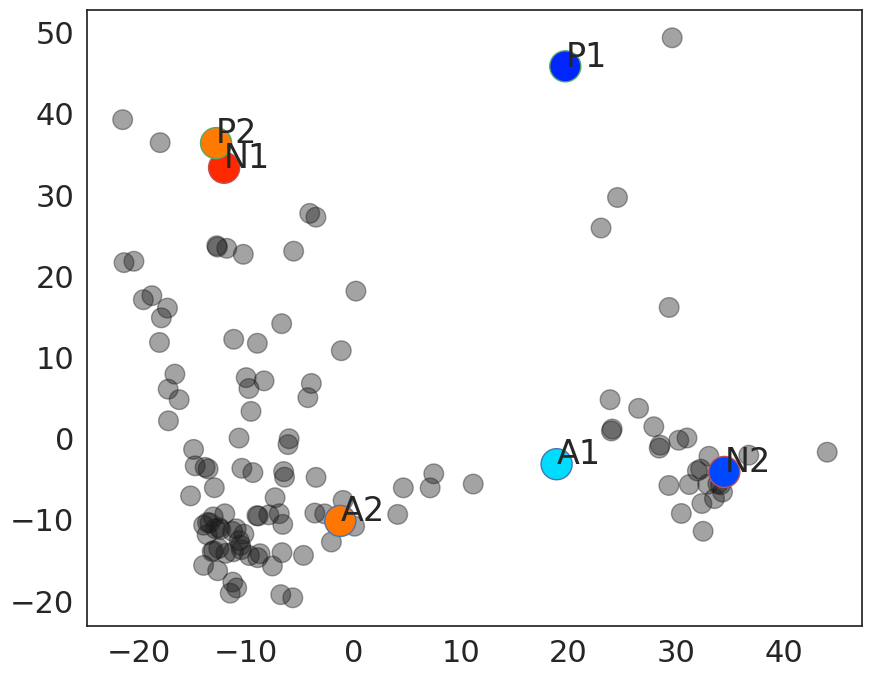

In [183]:
dfs['chemblid'] = dfs.index.map(dfm['Molecule ChEMBL ID'])
dfs['pred'] = predictions
dfs['true'] = dfs.index.map(dfm['pChEMBL'])

dfs['node_color'] = dfs.index.map(dfm['node_color'])
dfs['edgecolor'] = dfs.index.map(dfm['edgecolor'])
dfs['node_size'] = dfs.index.map(dfm['node_size'])
dfs['label'] = dfs.index.map(dfm['label'])

dfs1 = dfs[dfs.label == 'data']
dfs2 = dfs[dfs.label != 'data']

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = 'k', alpha = 0.4, s = dfs1.node_size, edgecolors = dfs1.edgecolor)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, edgecolors = dfs2.edgecolor)
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)
    

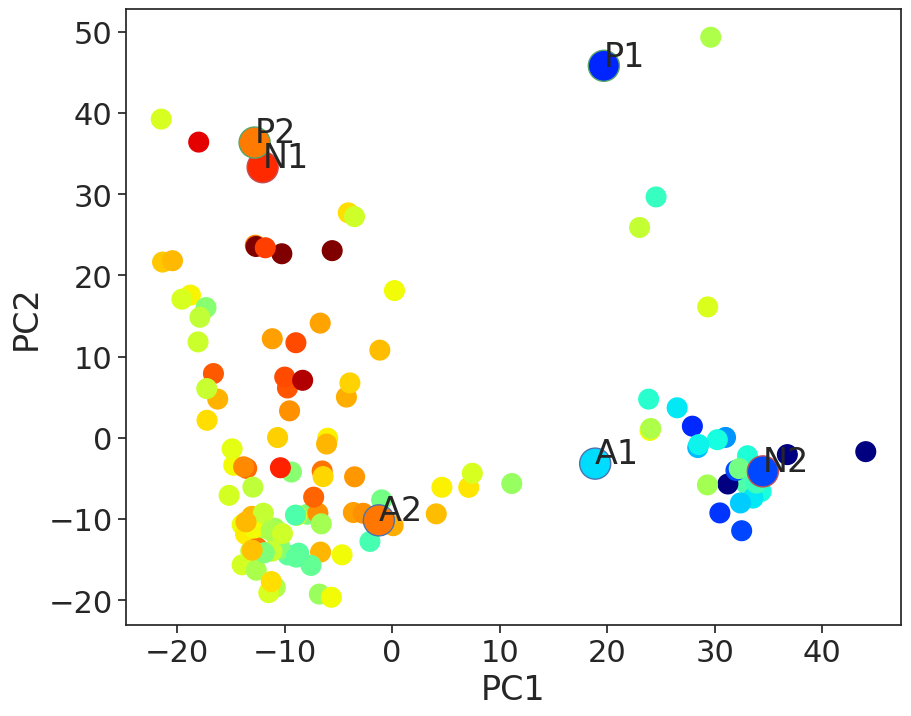

In [184]:

dfm = pd.read_csv('./results/chemical_space.csv', index_col='smiles')

a, p, n = "CHEMBL3661243", "CHEMBL3661245", "CHEMBL1357167" 
dfs['chemblid'] = dfs.index.map(dfm['Molecule ChEMBL ID'])
dfs['pred'] = predictions
dfs['true'] = dfs.index.map(dfm['pChEMBL'])

dfs['node_color'] = dfs.index.map(dfm['node_color'])
dfs['edgecolor'] = dfs.index.map(dfm['edgecolor'])
dfs['node_size'] = dfs.index.map(dfm['node_size'])
dfs['label'] = dfs.index.map(dfm['label'])

dfs1 = dfs[dfs.label == 'data']
dfs2 = dfs[dfs.label != 'data']

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = dfs1.node_color,s = dfs1.node_size,)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, edgecolors = dfs2.edgecolor)
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)
    
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

fig.savefig('./results/braf_latent_sapce_no_ACA.pdf', dpi = 300, bbox_inches='tight')

In [185]:
dfs1[(dfs1.dim1 < -10 ) & (dfs1.dim2 > 30)].sort_values('true')

,dim1,dim2,chemblid,pred,true,node_color,edgecolor,node_size,label
CCS(=O)(=O)Nc1ccc(-c2ccc3ncnc(Nc4ccccc4)c3c2)cc1,-17.985603,36.424831,CHEMBL3661214,5.803434,5.74,#e40000,k,200,data
Clc1ccc(-c2ccc3ncnc(Nc4cccc5[nH]ncc45)c3c2)cc1,-21.471304,39.255424,CHEMBL3661257,6.470558,6.54,#d7ff1f,k,200,data


In [186]:
#COc1cc(-c2ccc3ncnc(Nc4ccc(F)c(Cl)c4)c3c2)ccc1O;CHEMBL3661204;1088.0 nM
#COc1cc(-c2ccc3ncnc(Nc4ccc(F)c(O)c4)c3c2)ccc1O;CHEMBL3665862;23.4 nM

dfs1[dfs1.chemblid == 'CHEMBL3661205']

,dim1,dim2,chemblid,pred,true,node_color,edgecolor,node_size,label
COc1cc(-c2ccc3ncnc(Nc4ccc(F)cc4)c3c2)ccc1O,-9.731599,6.150984,CHEMBL3661205,6.010697,5.99,#ff5500,k,200,data


In [187]:

dfs1[(dfs1.dim1 < 30) & (dfs1.dim2 < 0) & (dfs1.true > 6.9 )] # CHEMBL3665861


,dim1,dim2,chemblid,pred,true,node_color,edgecolor,node_size,label
COc1cccc(-c2ccc3nccc(Nc4cccc5[nH]ncc45)c3c2)c1F,-2.058750,-12.746029,CHEMBL3661286,6.978286,7.00,#46ffb1,k,200,data
COc1ccc(-c2ccc3nccc(Nc4cccc5[nH]ncc45)c3c2)cc1C=O,-9.683268,-14.418667,CHEMBL3661291,6.973370,6.93,#5dff9a,k,200,data
NC(=O)c1cccc(-c2ccc3nccc(Nc4cccc5[nH]ncc45)c3c2)c1,-8.693427,-14.189774,CHEMBL3639601,6.890073,6.95,#56ffa0,k,200,data
COc1cc(-c2cc3c(Nc4cc(O)ccc4Cl)ncnc3cc2OC)ccc1O,28.424387,-1.187792,CHEMBL3661227,7.145023,7.33,#00bcff,k,200,data
COc1cc(-c2ccc3ncnc(Nc4cc(O)ccc4Cl)c3c2)ccc1O,28.518072,-0.824624,CHEMBL3661238,7.266237,7.19,#0cf4eb,k,200,data
N#Cc1cccc(-c2ccc3nccc(Nc4cccc5[nH]ncc45)c3c2)c1,-7.546485,-15.700894,CHEMBL3661289,6.924738,6.91,#63ff94,k,200,data
CS(=O)(=O)c1ccc(-c2ccc3nccc(Nc4cccc5[nH]ncc45)c3c2)cc1,-8.912079,-14.681395,CHEMBL3661294,6.904451,6.93,#5dff9a,k,200,data
COc1ccc(-c2ccc3ncnc(Nc4cccc5[nH]ncc45)c3c2)cc1C=O,-8.987754,-9.502938,CHEMBL3661274,7.019953,6.98,#4dffaa,k,200,data


In [188]:
dfs2.sort_values('edgecolor')

,dim1,dim2,chemblid,pred,true,node_color,edgecolor,node_size,label
COc1ccc(Nc2ncnc3ccc(-c4ccc(O)c(OC)c4)cc23)cc1O,-1.233354,-10.151571,CHEMBL3661215,6.147609,6.08,#ff7700,b,250,A2
COc1cc(-c2ccc3ncnc(Nc4cccc(O)c4Cl)c3c2)ccc1O,18.884428,-3.165730,CHEMBL3661239,7.221684,7.25,#00dcfe,b,250,A1
Oc1cc(Nc2ncnc3ccc(-c4ccc(Cl)cc4)cc23)c(F)cc1F,19.691124,45.821144,CHEMBL3665861,7.709244,7.72,#0025ff,g,250,P1
COc1cc(-c2ccc3ncnc(Nc4ccc(Cl)cc4F)c3c2)ccc1O,-12.787132,36.368465,CHEMBL3661206,6.068812,6.09,#ff7a00,g,250,P2
COc1cc(-c2ccc3ncnc(Nc4ccc(F)c(O)c4)c3c2)ccc1O,34.479183,-4.123106,CHEMBL3665862,7.596289,7.63,#0048ff,r,250,N2
COc1cc(-c2ccc3ncnc(Nc4ccc(Cl)cc4O)c3c2)ccc1O,-12.039197,33.335190,CHEMBL3661211,5.889331,5.87,#ff2900,r,250,N1


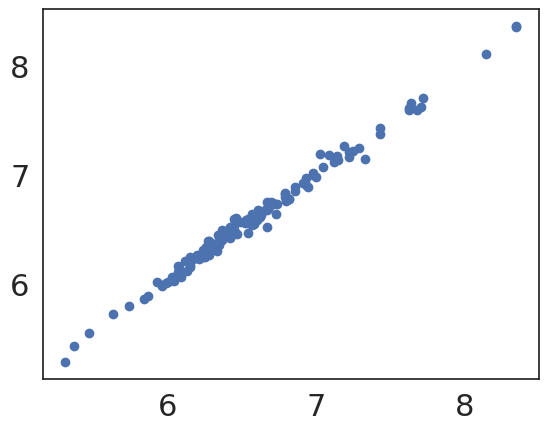

In [189]:
plt.scatter(dfs.true, dfs.pred,)

In [190]:
dfs.to_csv('./results/latent_space_no_aca.csv')

In [191]:
# dfh.to_csv('./results/history_no_aca.csv')